### <p style="text-align: right;"> Alexis Guevara

# Solve 1D initial/boundary-value problem  

### Preliminary Functions

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from mpl_toolkits.mplot3d import Axes3D


#### Band Functions

In [6]:
def bandLU(K, p, q):
    """
    INPUTS - K: 2D numpy array representing the banded matrix to be factored
             p: an integer representing the lower bandwidth
             q: an integer representing the upper bandwidth
    OUTPUT - K: 2D numpy array
    """
    n = len(K) # Size of Matrix K
    for m in range(n - 1):
        # Update lower triangular part of matrix K
        for i in range(m + 1, min(m + p + 1, n)):
            K[i, m] /= K[m, m]
        # Update upper triangular part of matrix K
        for j in range(m + 1, min(m + q + 1, n)):
            for i in range(m + 1, min(m + p + 1, n)):
                K[i, j] -= K[i, m] * K[m, j]
    return K # Updated version of matrix K

In [7]:
def bandforward(L, f, p):
    """
    INPUTS - L: 2D numpy array representing the banded lower triangular matrix
             f: 1D numpy array representing the RHS of the matrix equation Lz = f
             p: an integer representing the lower bandwidth
    OUTPUT - z: 1D numpy array representing the solution of Lz = f
    """
    n = len(L)  # Size of Matrix L
    z = np.zeros(n) # Initialize solution vector of Lz = f

    for i in range(n):
        z[i] = f[i] # Start with first value
        for j in range(max(0, i - p), i):
            z[i] = z[i] - L[i, j] * z[j]
        z[i] = z[i] / L[i, i]  # Divide by diagonal element of matrix L
    return z

In [8]:
def bandbackward(U, f, q):
    """
    INPUTS - U: 2D numpy array representing the banded upper triangular matrix
             f: 1D numpy array representing the RHS of the matrix equation Uw = f
             q: an integer representing the upper bandwidth
    OUTPUT - w: 1D numpy array representing the solution of Uw = f
    """
    n = len(U)
    w = np.zeros(n) # Initialize solution vector of Uw = f
    for i in range(n-1, -1, -1):
        w[i] = f[i]  # Start with last value
        for j in range(i + 1, min(i + q + 1, n)):
            w[i] = w[i] - U[i, j] * w[j]
        w[i] = w[i] / U[i, i]  # Divide by diagonal element of matrix U
    return w

#### Shape Functions

In [10]:
# linear and quadratic 1D shape functions 
def shapeFn1d(i:int,x:np.array,x1:np.array,x2:np.array,p:int):
    '''
    these are the linear and quadratic shape functions on a 1-d element [x1,x2]
    y = shapeFn1d(i,x,x1,x2,p)
    
    input:
       i: i-th shape function
       x: input for shape function
       x1, x2: end points for the 1d element, x1 < x2
       p: order of shape function
    output:
       y: the shapeFn(x)
    '''
    
    if (np.ndim(x) == 0):
        #print('x is a scalar')
        x = np.array([x])

    if (np.ndim(x1) == 0):
        #print('x1 is a scalar')
        x1 = np.array([x1])

    if (np.ndim(x2) == 0):
        #print('x2 is a scalar')
        x2 = np.array([x2])

    ind = np.where((x < x2+1e-12) & (x > x1-1e-12))[0]

    y = np.zeros(x.shape)
  
    # linear shape functions
    if (p == 1):
        if (i == 1):
            y[ind] = (x2[ind] - x[ind])/(x2[ind] - x1[ind])
        elif (i == 2):
            y[ind] = (x[ind] - x1[ind])/(x2[ind] - x1[ind])
        else:
            y = np.array([])
   

    # quadratic shape functions
    if (p == 2):
        if (i == 1):
            y[ind] = (x2[ind] - x[ind])*(x2[ind]-2*x[ind]+x1[ind])/((x2[ind]-x1[ind])**2)
        elif (i == 2):
            y[ind] = 4*(x[ind]-x1[ind])*(x2[ind]-x[ind])/((x2[ind]-x1[ind])**2)
        elif (i == 3):
            y[ind] = (x1[ind]-x[ind])*(x2[ind]-2*x[ind]+x1[ind])/((x2[ind]-x1[ind])**2)
        else:
            y = np.array([])
   

    if ((p != 1) and (p != 2)):
        y = np.array([])

    return y


# derivatives of linear and quadratic 1D shape functions 
def shapeFnDer1d(i: int,x:np.array,x1:np.array,x2:np.array,p:int):
    '''
    these are the linear and quadratic shape functions on a 1-d element [x1,x2]
    y = shapeFnDer1d(i,x,x1,x2,p)

    input:
      i: i-th shape function
      x: input for shape function
      x1, x2: end points for the 1d element, x1 < x2
      p: order of shape function
    output:
      y: thise shapeFnDer(x)
    '''

    if (np.ndim(x) == 0):
        #print('x is a scalar')
        x = np.array([x])

    if (np.ndim(x1) == 0):
        #print('x1 is a scalar')
        x1 = np.array([x1])

    if (np.ndim(x2) == 0):
        #print('x2 is a scalar')
        x2 = np.array([x2])

    ind = np.where((x < x2+1e-12) & (x > x1-1e-12))[0]
    if ((type(x) == float) or (type(x) == np.float64)):
        x = np.array([x])

    y = np.zeros(x.shape)

    # linear shape function
    if (p == 1):
        if (i == 1):
            y[ind] = -1.0/(x2[ind] - x1[ind])
        elif (i == 2):
            y[ind] = 1.0/(x2[ind] - x1[ind])
        else:
            y = np.array([])
    

    # quadratic shape function
    if (p == 2):
        if (i == 1):
            y[ind] = (-3.0*x2[ind] + 4.*x[ind] - x1[ind])/((x2[ind]-x1[ind])**2)
        elif (i == 2):
            y[ind] = 4.0*(x2[ind]-2.0*x[ind]+x1[ind])/((x2[ind]-x1[ind])**2)
        elif (i == 3):
            y[ind] = (-x2[ind]+4.0*x[ind]-3.0*x1[ind])/((x2[ind]-x1[ind])**2)
        else:
            y = np.array([])

    if ( (p != 1) and (p != 2)):
        y = np.array([])

    return y

#### Gaussian Quadrature

In [12]:
 def gaussQuadStd1d(g, noOfIntegPt):
    """
    TASK   - Evaluate definite integral of G(ξ) from -1 to 1 using Gaussian quadrature

    INPUTS - g           : function representing the integrand
             noOfIntegPt : number of integration points
    OUTPUT - y           : value of integral
    """
    if noOfIntegPt == 2:
        # Coefficients and points for 2-point Gaussian quadrature
        weights = [1.0, 1.0]
        points = [-1/(3 ** 0.5) , 1/(3 ** 0.5)]
    elif noOfIntegPt == 3:
        # Coefficients and points for 3-point Gaussian quadrature
        weights = [5/9, 8/9, 5/9]
        points = [-((3 / 5) ** 0.5), 0.0, ((3 / 5) ** 0.5)]
    else:
        raise ValueError("Only 2 or 3 integration points are supported.")

    # Compute integral using quadrature formula
    integral = 0.0
    for i in range(len(points)):
        integral += weights[i] * g(points[i])

    return integral

In [13]:
def gaussQuad1d(fn, lowerLimit, upperLimit, noOfIntegPt):
    """
    TASK   - Evaluate definite integral of fn(x) from lowerLimit to upperLimit using Gaussian quadrature

    INPUTS - fn          : function representing the integrand
             lowerLimit  : lower integration limit (a)
             upperLimit  : upper integration limit (b)
             noOfIntegPt : number of integration points
    OUTPUT - y           : value of integral
    """
    # Create transformation from [a, b] to [-1, 1]
    def transform(xi):
        return 0.5 * (upperLimit - lowerLimit) * xi + 0.5 * (upperLimit + lowerLimit)

    # Define transformed integrand
    def transformedfn(xi):
        x = transform(xi)  # Change of variables x to ξ
        return ( (upperLimit - lowerLimit) / 2 ) * fn(x)

    # Use gaussQuadStd1d to compute integral on [-1, 1]
    return gaussQuadStd1d(transformedfn, noOfIntegPt)

#### Construct Local and Global M,K,F Matrices

In [15]:
def meij(e, i, j, xh, shapeFn, noOfIntegPt):
    """
    TASK   - Evaluate (i, j)-th entry of the element mass matrix M^e

    INPUTS - e           : element index
             i,j         : indices for the mass matrix entry
             xh          : array of element nodes [x_1, x_2, ..., x_n+1]
             shapeFn     : degree of shape functions (1 = linear, 2 = quadratic)
             noOfIntegPt : number of integration points for Gaussian quadrature
    OUTPUT - y           : value
    """
    x1 = xh[e - 1]  # Left boundary of the e-th element
    x2 = xh[e]      # Right boundary of the e-th element

    def integrand(x):
        # Product of shape functions psi_i and psi_j
        return shapeFn1d(i, x, x1, x2, shapeFn) * shapeFn1d(j, x, x1, x2, shapeFn)

    # Perform integration using Gaussian quadrature
    y = gaussQuad1d(integrand, x1, x2, noOfIntegPt)
    return y


def keij(a, c, e, i, j, xh, shapeFn, noOfIntegPt):
    """
    TASK   - Evaluate (i, j)-th entry of element stiffness matrix K^e

    INPUTS - a           : function 
             c           : function 
             e           : element index
             i,j         : indices for the stiffness matrix entry
             xh          : array of element nodes [x_1, x_2, ..., x_n+1]
             shapeFn     : degree of shape functions (1 = linear, 2 = quadratic)
             noOfIntegPt : number of integration points for Gaussian quadrature
    OUTPUT - y           : value
    """
    x1 = xh[e - 1]  # Left boundary of the e-th element
    x2 = xh[e]      # Right boundary of the e-th element

    def integrand(x):
        # Retrieve shape functions and derivatives
        psi_i = shapeFn1d(i, x, x1, x2, shapeFn)
        psi_j = shapeFn1d(j, x, x1, x2, shapeFn)
        psi_i_Der = shapeFnDer1d(i, x, x1, x2, shapeFn)
        psi_j_Der = shapeFnDer1d(j, x, x1, x2, shapeFn)

        # Contribution from derivative-dependent and non-derivative terms
        return a(x) * psi_i_Der * psi_j_Der + c(x) * psi_i * psi_j

    # Perform integration using Gaussian quadrature
    y = gaussQuad1d(integrand, x1, x2, noOfIntegPt)
    
    return y


def fei(a, c, f, p0, e, i, xh, shapeFn, noOfIntegPt):
    """
    TASK   - Evaluate i-th entry of element load vector F^e

    INPUTS - a           : function 
             c           : function 
             f           : load function in boundary value problem
             p0          : dirichlet boundary condition for solution at x=0
             e           : element index
             i           : index for the load vector entry
             xh          : array of element nodes [x_1, x_2, ..., x_n+1]
             shapeFn     : degree of shape functions (1 = linear, 2 = quadratic)
             noOfIntegPt : number of integration points for Gaussian quadrature
    OUTPUT - y           : value
    """
    x1 = xh[e - 1]  # Left boundary of the e-th element
    x2 = xh[e]      # Right boundary of the e-th element

    def integrand(x):
        # Retrieve shape functions and derivatives
        psi_i = shapeFn1d(i, x, x1, x2, shapeFn)
        psi_i_Der = shapeFnDer1d(i, x, x1, x2, shapeFn)
        
        # Product of load function and shape function psi_i
        return ( f(x)*psi_i 
                - (a(x)*p0*shapeFnDer1d(1, x, xh[0], xh[1], shapeFn)*psi_i_Der) 
                - (c(x)*p0*shapeFn1d(1, x, xh[0], xh[1], shapeFn)*psi_i)
               )

    # Perform numerical integration using Gaussian quadrature
    y = gaussQuad1d(integrand, x1, x2, noOfIntegPt)

    return y

In [16]:
def massM(xh, shapeFn, noOfIntegPt):
    """
    Construct global consistent mass matrix M without extra zero row/column
    
    Parameters:
    xh : array of element nodes [x_1, x_2, ..., x_{n+1}]
    shapeFn : degree of shape functions (1 = linear, 2 = quadratic)
    noOfIntegPt : number of integration points for Gaussian quadrature
    
    Returns:
    M : sparse matrix representing global mass matrix without extra zeros
    """
    
    n = len(xh) - 1  # number of elements
    
    # Determine matrix size based on shape functions
    if shapeFn == 1:
        size = n  # For linear, we have n+1 nodes but first node is Dirichlet
    elif shapeFn == 2:
        size = 2 * n  # For quadratic, we have 2n+1 nodes but first node is Dirichlet
    else:
        raise ValueError("shapeFn must be 1 (linear) or 2 (quadratic)")
    
    M = lil_matrix((size, size))
    
    for e in range(1, n + 1):
        if shapeFn == 1:
            # Linear shape functions (2 nodes per element)
            if e == 1:
                # Only right node contributes (left node has Dirichlet condition)
                M[0, 0] += meij(e, 2, 2, xh, shapeFn, noOfIntegPt)
            else:
                i_global = e - 1
                M[i_global-1, i_global-1] += meij(e, 1, 1, xh, shapeFn, noOfIntegPt)
                M[i_global-1, i_global] += meij(e, 1, 2, xh, shapeFn, noOfIntegPt)
                M[i_global, i_global-1] += meij(e, 2, 1, xh, shapeFn, noOfIntegPt)
                M[i_global, i_global] += meij(e, 2, 2, xh, shapeFn, noOfIntegPt)

        elif shapeFn == 2:
            # Quadratic shape functions (3 nodes per element)
            if e == 1:
                # First element: skip the first DOF (Dirichlet condition)
                M[0, 0] += meij(e, 2, 2, xh, shapeFn, noOfIntegPt)
                M[0, 1] += meij(e, 2, 3, xh, shapeFn, noOfIntegPt)
                M[1, 0] += meij(e, 3, 2, xh, shapeFn, noOfIntegPt)
                M[1, 1] += meij(e, 3, 3, xh, shapeFn, noOfIntegPt)
            else:
                i_global = 2*(e-1) - 1
                
                # Row 1
                M[i_global, i_global] += meij(e, 1, 1, xh, shapeFn, noOfIntegPt)
                M[i_global, i_global+1] += meij(e, 1, 2, xh, shapeFn, noOfIntegPt)
                M[i_global, i_global+2] += meij(e, 1, 3, xh, shapeFn, noOfIntegPt)
                
                # Row 2
                M[i_global+1, i_global] += meij(e, 2, 1, xh, shapeFn, noOfIntegPt)
                M[i_global+1, i_global+1] += meij(e, 2, 2, xh, shapeFn, noOfIntegPt)
                M[i_global+1, i_global+2] += meij(e, 2, 3, xh, shapeFn, noOfIntegPt)
                
                # Row 3
                M[i_global+2, i_global] += meij(e, 3, 1, xh, shapeFn, noOfIntegPt)
                M[i_global+2, i_global+1] += meij(e, 3, 2, xh, shapeFn, noOfIntegPt)
                M[i_global+2, i_global+2] += meij(e, 3, 3, xh, shapeFn, noOfIntegPt)
    
    return M

In [17]:
def stiffK(a, c, xh, shapeFn, noOfIntegPt):
    """
    Construct global stiffness matrix K without extra zero row/column
    
    Parameters:
    a, c : coefficient functions
    xh : array of element nodes [x_1, x_2, ..., x_{n+1}]
    shapeFn : degree of shape functions (1 = linear, 2 = quadratic)
    noOfIntegPt : number of integration points for Gaussian quadrature
    
    Returns:
    K : sparse matrix representing global stiffness matrix without extra zeros
    """
    
    n = len(xh) - 1  # number of elements
    
    # Determine matrix size based on shape functions
    if shapeFn == 1:
        size = n  # For linear, we have n+1 nodes but first node is Dirichlet
    elif shapeFn == 2:
        size = 2 * n  # For quadratic, we have 2n+1 nodes but first node is Dirichlet
    else:
        raise ValueError("shapeFn must be 1 (linear) or 2 (quadratic)")
    
    K = lil_matrix((size, size))
    
    for e in range(1, n + 1):
        if shapeFn == 1:
            # Linear shape functions
            if e == 1:
                # Only right node contributes (left node has Dirichlet condition)
                K[0, 0] += keij(a, c, e, 2, 2, xh, shapeFn, noOfIntegPt)
            else:
                i_global = e - 1
                K[i_global-1, i_global-1] += keij(a, c, e, 1, 1, xh, shapeFn, noOfIntegPt)
                K[i_global-1, i_global] += keij(a, c, e, 1, 2, xh, shapeFn, noOfIntegPt)
                K[i_global, i_global-1] += keij(a, c, e, 2, 1, xh, shapeFn, noOfIntegPt)
                K[i_global, i_global] += keij(a, c, e, 2, 2, xh, shapeFn, noOfIntegPt)

        elif shapeFn == 2:
            # Quadratic shape functions
            if e == 1:
                # First element: skip the first DOF (Dirichlet condition)
                K[0, 0] += keij(a, c, e, 2, 2, xh, shapeFn, noOfIntegPt)
                K[0, 1] += keij(a, c, e, 2, 3, xh, shapeFn, noOfIntegPt)
                K[1, 0] += keij(a, c, e, 3, 2, xh, shapeFn, noOfIntegPt)
                K[1, 1] += keij(a, c, e, 3, 3, xh, shapeFn, noOfIntegPt)
            else:
                i_global = 2*(e-1) - 1
                
                # Row 1
                K[i_global, i_global] += keij(a, c, e, 1, 1, xh, shapeFn, noOfIntegPt)
                K[i_global, i_global+1] += keij(a, c, e, 1, 2, xh, shapeFn, noOfIntegPt)
                K[i_global, i_global+2] += keij(a, c, e, 1, 3, xh, shapeFn, noOfIntegPt)
                
                # Row 2
                K[i_global+1, i_global] += keij(a, c, e, 2, 1, xh, shapeFn, noOfIntegPt)
                K[i_global+1, i_global+1] += keij(a, c, e, 2, 2, xh, shapeFn, noOfIntegPt)
                K[i_global+1, i_global+2] += keij(a, c, e, 2, 3, xh, shapeFn, noOfIntegPt)
                
                # Row 3
                K[i_global+2, i_global] += keij(a, c, e, 3, 1, xh, shapeFn, noOfIntegPt)
                K[i_global+2, i_global+1] += keij(a, c, e, 3, 2, xh, shapeFn, noOfIntegPt)
                K[i_global+2, i_global+2] += keij(a, c, e, 3, 3, xh, shapeFn, noOfIntegPt)
    
    return K

In [18]:
def loadF(a, c, f, p0, QL, xh, shapeFn, noOfIntegPt):
    """
    Construct global load vector F without extra zero entry
    
    Parameters:
    a, c, f : coefficient functions
    p0 : Dirichlet BC at x=0
    QL : Neumann BC at x=L (a * du/dn)
    xh : array of element nodes [x_1, x_2, ..., x_{n+1}]
    shapeFn : degree of shape functions (1 = linear, 2 = quadratic)
    noOfIntegPt : number of integration points for Gaussian quadrature
    
    Returns:
    F : 1D numpy array representing global load vector without extra zeros
    """
    
    n = len(xh) - 1  # number of elements
    
    # Determine vector size based on shape functions
    if shapeFn == 1:
        size = n  # For linear, we have n+1 nodes but first node is Dirichlet
    elif shapeFn == 2:
        size = 2 * n  # For quadratic, we have 2n+1 nodes but first node is Dirichlet
    else:
        raise ValueError("shapeFn must be 1 (linear) or 2 (quadratic)")
    
    F = np.zeros(size)
    
    for e in range(1, n + 1):
        if shapeFn == 1:
            # Linear shape functions
            if e == 1:
                # Only right node contributes (left node has Dirichlet condition)
                F[0] += fei(a, c, f, p0, e, 2, xh, shapeFn, noOfIntegPt)
            else:
                i_global = e - 1
                F[i_global-1] += fei(a, c, f, p0, e, 1, xh, shapeFn, noOfIntegPt)
                F[i_global] += fei(a, c, f, p0, e, 2, xh, shapeFn, noOfIntegPt)

        elif shapeFn == 2:
            # Quadratic shape functions
            if e == 1:
                # First element: skip the first DOF (Dirichlet condition)
                F[0] += fei(a, c, f, p0, e, 2, xh, shapeFn, noOfIntegPt)
                F[1] += fei(a, c, f, p0, e, 3, xh, shapeFn, noOfIntegPt)
            else:
                i_global = 2*(e-1) - 1
                F[i_global] += fei(a, c, f, p0, e, 1, xh, shapeFn, noOfIntegPt)
                F[i_global+1] += fei(a, c, f, p0, e, 2, xh, shapeFn, noOfIntegPt)
                F[i_global+2] += fei(a, c, f, p0, e, 3, xh, shapeFn, noOfIntegPt)
    
    # Add Neumann boundary condition at x=L
    if shapeFn == 1:
        F[-1] += QL  # Last node for linear
    elif shapeFn == 2:
        F[-1] += QL  # Last node for quadratic
    
    return F

#### L2 Norm

In [20]:
def L2norm1d(f, a, b, noOfEle):
    """
    TASK - Compute L2 norm of a one-variable L2 function using Gaussian quadrature

    INPUTS - f        : function 
             a, b     : endpoints of the domain [a, b]
             noOfEle  : number of subintervals to divide [a, b]
    OUTPUT - norm     : computed L2 norm (scalar)
    """
    # Subinterval size
    h = (b - a) / noOfEle

    # Initialize norm
    norm = 0.0

    for e in range(noOfEle):
        # Define element endpoints
        x_start = a + e * h
        x_end = x_start + h

        # Define integrand for current subinterval (f(x)^2)
        def integrand(x):
            return f(x) ** 2

        # Use gaussQuad1d to integrate over current subinterval
        integral = gaussQuad1d(integrand, x_start, x_end, 3)  # 3 integration points

        norm += integral

    # Compute square root of integral
    return np.sqrt(norm)

#### Assemble 1D

In [22]:
##--------------------------------------------------
# assemble solution on the nodes and give the solution function
##--------------------------------------------------
def approxSol(w: np.array, p0: float, xh: np.array, shapeFn:int):
    '''
    This function takes the solution of the values of the nodes and gives the
    approximated solution on the interval [0,L]
    [uh] = approxSol(w, u0, xh, shapeFn)
    where
        w is the values of the nodes excluding the node value at x=0, 
        p0 is the Dirichlet BC at x = 0, 
        xh = [x_1,x_2,...,x_{n+1}] is the list of endpoints of all elements, 
        shapeFn indicates the choice of linear (use 1) or quadratic (use 2) shape functions     
    '''
    w = np.hstack((p0, w))

    if (shapeFn == 1): # if linear shape functions are used
        uh = lambda x: linearApprox(x,w,xh)
    else:    # if quadratic shape functions are used
        uh = lambda x: quadraticApprox(x,w,xh)

    return uh

##--------------------------------------------------
# assemble linear shape functions on the whole domain
##-------------------------------------------------
def linearApprox(x: np.array, v: np.array,xh: np.array):
    if (np.ndim(x) == 0):
        #print('x is a scalar')
        x = np.array([x])

    # declare the output array
    y = np.zeros(len(x))

    # mesh size
    h = xh[1]-xh[0]

    # determine which subinterval x belongs to 
    ind = np.floor(x/h).astype(int)
    x1 = h * ind
    x2 = x1 + h
    ind = ind+1

    
    # the right end point x=L
    indLastPt = np.where(ind == len(v))[0]
    y[indLastPt] = v[-1]

    
    indNotLastPt = np.where(ind < len(v))[0]
    y[indNotLastPt] = v[ind[indNotLastPt]-1] * shapeFn1d(1,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],1) + \
        v[ind[indNotLastPt]] * shapeFn1d(2,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],1)
    
    return y
    
##--------------------------------------------------
# assemble quadratic shape functions on the whole domain
##-------------------------------------------------
def quadraticApprox(x: np.array,v: np.array,xh: np.array):
    if (np.ndim(x) == 0):
        #print('x is a scalar')
        x = np.array([x])
        
    # declare the output array
    y = np.zeros(len(x))

    # mesh size
    h = xh[1]-xh[0] 

    # determine which subinterval x belongs to 
    ind = np.floor(x/h).astype(int)
    x1 = ind*h  
    x2 = x1+h
    ind = ind+1

    # the right end point x=L
    indLastPt = np.where(ind == (len(v)+1)/2)[0]
    y[indLastPt] = v[-1]

    indNotLastPt = np.where(ind < (len(v)+1)/2)[0]

    y[indNotLastPt] = v[2*ind[indNotLastPt]-2] * shapeFn1d(1,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2)\
            + v[2*ind[indNotLastPt]-1] * shapeFn1d(2,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2) \
            + v[2*ind[indNotLastPt]] * shapeFn1d(3,x[indNotLastPt],x1[indNotLastPt],x2[indNotLastPt],2)

    return y

### Main Function

In [24]:
def myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, shapeFn):
    """
    TASK - Solve 1D initial/boundary-value problem
    
    INPUTS: 
    a, c, f - Coefficient functions
    p0      - Boundary condition
    QL      - Boundary condition function Q_L(t) at x=L
    u0      - Initial condition function u_0(x)
    L       - Right endpoint of domain (0,L)
    T       - Ending time
    dt      - Time step size
    noOfEle - Number of elements
    shapeFn - Degree of shape functions (1 = linear, 2 = quadratic)
    
    OUTPUTS:
    uh  - array of functions representing approximated solution at each time step
    W   - array of solution vectors at each time step 
    """
    
    # Discretize domain and time interval
    xh = np.linspace(0, L, noOfEle + 1)
    nt = int(np.ceil(T / dt)) + 1
    time_steps = np.linspace(0, T, nt)
    
    # Initialize uh and W
    if shapeFn == 1:
        size_W = noOfEle      # Linear elements
    else:
        size_W = 2 * noOfEle  # Quadratic elements
        
    W = np.zeros((size_W, nt))
    uh = np.empty(nt, dtype=object)
    
    # Set initial conditions for uh and W
    uh[0] = u0
    
    # Initialize W[:,0] based on degree of shape functions
    if shapeFn == 1:
        # Linear elements: evaluate at nodes (excluding x=0)
        W[:, 0] = u0(xh[1:])
    else:
        # Quadratic elements: evaluate at midpoints and endpoints
        for e in range(noOfEle):
            x1 = xh[e]
            x2 = xh[e+1]
            W[2*e, 0] = u0((x1 + x2)/2)   # Midpoint value
            W[2*e + 1, 0] = u0(x2)        # Right node value
    
    # Construct matrices M and K 
    if shapeFn == 1:  
        noOfIntegPt = 2 # Linear elements
    else:
        noOfIntegPt = 3 # Quadratic elements
    
    # Convert to dense arrays
    M = massM(xh, shapeFn, noOfIntegPt).toarray()
    K = stiffK(a, c, xh, shapeFn, noOfIntegPt).toarray()
    
    # 5. Form time-stepping matrices
    A = M + 0.5 * dt * K
    B = M - 0.5 * dt * K
    
    # Determine bandwidth
    if shapeFn == 1:  # Linear Elements
        p = 1  # lower bandwidth 
        q = 1  # upper bandwidth 
    else:  # Quadratic elements
        p = 2  # lower bandwidth 
        q = 2  # upper bandwidth 
    
    # Factor A into L and U
    A_factored = A.copy()
    A_factored = bandLU(A_factored, p, q)
    
    # Extract L and U from the factored matrix
    n = A.shape[0]
    L = np.eye(n)         
    U = np.zeros((n, n))  
    
    # Fill L (lower triangular matrix) and U (upper triangular matrix)
    for i in range(n):
        for j in range(n):
            if j > i:  # Upper triangular (including diagonal)
                U[i,j] = A_factored[i,j]
            elif j < i:  # Lower triangular (excluding diagonal)
                L[i,j] = A_factored[i,j]
            else:  # Diagonal
                U[i,i] = A_factored[i,i]
    
    # 6. Time-stepping loop
    for n in range(nt - 1):
        t_curr = time_steps[n]
        t_next = time_steps[n+1]
        
        # Current and next load vectors
        F_curr = loadF(a, c, lambda x: f(x, t_curr), p0, QL(t_curr), xh, shapeFn, noOfIntegPt)
        F_next = loadF(a, c, lambda x: f(x, t_next), p0, QL(t_next), xh, shapeFn, noOfIntegPt)
        
        # Form right-hand side
        rhs = B @ W[:, n] + 0.5 * dt * (F_curr + F_next)
        
        # Solve using banded forward/backward substitution        
        y = bandforward(L, rhs, p)         # Forward substitution:  solve L*y = rhs
        W[:, n+1] = bandbackward(U, y, q)  # Backward substitution: solve U*x = y
        
        # Store solution function
        uh[n+1] = approxSol(W[:, n+1], p0, xh, shapeFn)
    
    return uh, W

#### Observed Case

In [26]:
a  = lambda x: 2+x
c  = lambda x: 1*x
f  = lambda x,t: (2 + 2*t - 4*x*t - 4*(x**2)*t)*np.cos(x) + (1 - 8*t - 6*x*t)*np.sin(x)
p0 = 1.
QL = lambda t: 2*t*(np.pi + 2)
u0 = lambda x: np.cos(x)
L  = np.pi
T  = 1.

### 1. Derivation of Weak Form of Boundary Value Problem

Consider the one-dimensional initial/boundary value problem:

\begin{equation}
    \begin{aligned}
        u_t - \frac{d}{dx}\left(a(x) \frac{du}{dx}\right) + c(x) u =&\,\, f(x,t) \quad 0<x<L , 0<t<T \\ 
        u(0,t) =&\,\, p_{0} \quad 0<t<T \\
        \left. a(x) \frac{du}{dx} \right\vert_{x=L} =&\,\, Q_{L}(t) \quad 0<t<T \\
        u(x,0) =&\,\, u_{0}(x) \quad 0 \leq x \leq L \\
    \end{aligned}
\end{equation}

To derive the weak form of the given initial/boundary value problem, we follow the steps below:

Choose a test function $v(x)$ such that $v(0) = 0$ (since $u$ is fixed at $x=0$, $v$ must vanish at $x=0$). Multiply the problem by $v(x)$ and integrate over the domain $(0,L)$:

\begin{equation}
    \int_{0}^{L} \left( u_t v - \frac{d}{dx}\left(a(x) \frac{du}{dx}\right)v + c(x) u v \right) dx = \int_{0}^{L} f(x,t) v \, dx .
\end{equation}

Use integration by parts on the term $-\frac{d}{dx}\left(a(x) \frac{du}{dx}\right)v$ to reduce the derivative order of $u(x,t)$:
\begin{equation}
    - \int_{0}^{L} \frac{d}{dx}\left(a(x) \frac{du}{dx}\right)v dx = \int_{0}^{L} a(x) \frac{du}{dx} \frac{dv}{dx} dx - \left[ v \, a(x) \frac{du}{dx} \right]_{0}^{L}.
\end{equation}

Note that at $x=0$, $v(0)=0$, and at $x=L$, $a(x) \frac{du}{dx} = Q_L(t)$. So the boundary term becomes $-v(L) Q_L(t)$.

So,
\begin{equation}
    - \int_{0}^{L} \frac{d}{dx}\left(a(x) \frac{du}{dx}\right)v dx = \int_{0}^{L} a(x) \frac{du}{dx} \frac{dv}{dx} dx - v(L) Q_L(t).
\end{equation}

Substituting the integrated term back into the equation:
\begin{equation}
    \int_{0}^{L} u_t v \, dx + \int_{0}^{L} a(x) \frac{du}{dx} \frac{dv}{dx} dx + \int_{0}^{L} c(x) u v \, dx = \int_{0}^{L} f(x,t) v \, dx + v(L) Q_L(t).
\end{equation}


Therefore, the weak form for the problem is the following:

Find $u(x,t) \in V_{1} = \{u \in H^{1}(0,L) | u(0,t) = p_0\}$ such that

\begin{equation}
    \int_{0}^{L} u_t v \, dx + \int_{0}^{L} a(x) \frac{du}{dx} \frac{dv}{dx} dx + \int_{0}^{L} c(x) u v \, dx = \int_{0}^{L} f(x,t) v \, dx + v(L) Q_L(t)
\end{equation}

holds $\forall v \in V_{2} = \{v \in H^{1}(0,L) | v(0) = 0\}$ .

### 2. Flow of Program

Since we are using the implicit method Crank-Nicolson as it is a second order method in time, the time step size is very restrictive and the method is unconditionally stable. Thus, we will take $\Delta t = h$ so time marching would not have to be slow. Since $x \in [0,L=\pi]$ and $t \in [0,T=1]$, we have $h = \frac{\pi}{100} \approx 0.03$. So, we will choose $dt = \Delta t = h \approx 0.03$, or simply $dt =  0.03$. 

### 3. Verification of Exact Solution of Initial/Boundary Value Problem

Consider the one-dimensional initial/boundary value problem:

\begin{equation}
    \begin{aligned}
        u_t - \frac{d}{dx}\left(a(x) \frac{du}{dx}\right) + c(x) u =&\,\, f(x,t) \quad 0<x<L , 0<t<T \\ 
        u(0,t) =&\,\, p_{0} \quad 0<t<T \\
        \left. a(x) \frac{du}{dx} \right\vert_{x=L} =&\,\, Q_{L}(t) \quad 0<t<T \\
        u(x,0) =&\,\, u_{0}(x) \quad 0 \leq x \leq L \\
    \end{aligned}
\end{equation}

Let 

\begin{equation}
    \begin{aligned}
        a(x) =&\,\, 2 + x, \\
        c(x) =&\,\, x, \\
        f(x,t) =&\,\, (2 + 2t - 4xt - 4x^{2}t) \cos(x) + (1 - 8t - 6xt) \sin(x), \\
        p_{0} =&\,\, 1, \\
        Q_{L}(t) =&\,\, 2t(\pi + t), \\
        u_{0}(x) =&\,\, \cos(x), \\
        L =&\,\, \pi , \\
        T =&\,\, 1. \\\
    \end{aligned}
\end{equation}

To verify that the exact solution $u(x,t) = (1 - 2xt)\cos(x)$ satisfies the given initial/boundary-value problem, we check whether the proposed solution satisfies the initial and boundary conditions. We must also verify if the proposed solution $u(x,t)$ satisfies the initial and boundary conditions.

#### Initial Condition:
At $t = 0$:
\begin{equation}
    u(x,0) = (1 - 0)\cos(x) = \cos(x) = u_0(x).
\end{equation}

#### Boundary Conditions:
At $x = 0$:
\begin{equation}
  u(0,t) = (1 - 0)\cos(0) = 1 = p_0.
\end{equation}

Computing $\frac{du}{dx}$, we get:
\begin{equation}
    \frac{du}{dx} = \frac{d}{dx} \left[(1 - 2xt) \cos(x) \right] = -\sin(x) - 2t\cos(x) + 2xt\sin(x) 
\end{equation}

So
\begin{equation}
    a(x)\frac{du}{dx} = -2\sin(x) - 4t\cos(x) + 4xt\sin(x) - x\sin(x) - 2xt\cos(x) + 2x^{2}t\sin(x) 
\end{equation}

At $x = L = \pi$:
\begin{equation}
    \begin{aligned}
    a(x)\frac{du}{dx}\bigg|_{x = \pi} =&\,\, 4t + 2\pi t \\
    =&\,\, 2t(\pi + 2) \\
    =&\,\, Q_{L}(t) \\
    \end{aligned}
\end{equation}

#### Substitution of $u(x,t)$ into Initial/Boundary Value Problem:

Substituting $u(x,t)$ in the initial/boundary value problem, computing each term in the problem, we get

\begin{equation}
    u_t = \frac{\partial}{\partial t}\left((1 - 2xt)\cos(x)\right) = -2x\cos(x) \\
\end{equation} 

\begin{equation}
    \frac{d}{dx}\left(a(x) \frac{du}{dx}\right) = -2\cos(x) + 4t\sin(x) + 4xt\cos(x) + 4t\sin(x) - \sin(x) - x\cos(x) -2t\cos(x) + 6xt\sin(x) + 2x^{2}t\cos(x)
\end{equation}

\begin{equation}
    c(x) u = x (1 - 2xt)\cos(x) = x\cos(x) - 2x^{2}t\cos(x). 
\end{equation}

Altogether, we get:
\begin{equation}
    \begin{aligned}
    u_t - \frac{d}{dx}\left(a(x) \frac{du}{dx}\right) + c(x) u =&\,\, -2x\cos(x) - \left(-2\cos(x) + 4t\sin(x) + 4xt\cos(x) + 4t\sin(x) - \sin(x) - x\cos(x) -2t\cos(x) + 6xt\sin(x) + 2x^{2}t\cos(x)\right) + x(1 - 2xt)\cos(x) \\
    =&\,\, ( 2 + 2t - 4xt - 4x^{2}t )\cos(x) + ( 1 - 8t - 6xt )\sin(x) \\
    =&\,\, f(x,t) \\
    \end{aligned}
\end{equation}

Thus, for the proposed solution $u(x,t) = (1 - 2xt)\cos(x)$, we obtain

\begin{equation}
    \begin{split}
        u(x,0) = \cos(x) = u_{0}(x)\\
        u(0, t) = 1 = p_{0} \quad \text{and} \quad a(x) \frac{du}{dx}\bigg|_{x = L = \pi} = 2t(\pi + 2) = Q_{L}\\
        u_t - \frac{d}{dx}\left(a(x) \frac{du}{dx}\right) + c(x) u = f(x,t). \\
    \end{split}
\end{equation}

Therefore, we have verified that $u(x,t) = (1 - 2xt)\cos(x)$ is the exact solution to the given initial/boundary-value problem.

### 4. Plot of Exact Solution and Computed Solutions

In [34]:
# Parameters for Observed Case
a = lambda x: 2+x
c = lambda x: 1*x
f = lambda x,t: (2 + 2*t - 4*x*t - 4*(x**2)*t)*np.cos(x) + (1 - 8*t - 6*x*t)*np.sin(x)
p0 = 1.
QL = lambda t: 2*t*(np.pi + 2)
u0 = lambda x: np.cos(x)
L = np.pi
T = 1.
dt = 0.03

# Exact solution for comparison
def exact_solution(x, t):
    return np.cos(x) - 2*x*t*np.cos(x)

# List of element counts (# of subintervals in domain)
element_counts = [16, 32, 64, 128]

# Store solutions
linear_solutions = {}
quadratic_solutions = {}

for noOfEle in element_counts:
    # Solve with linear elements
    uh_linear, W_linear = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, 1)
    linear_solutions[noOfEle] = uh_linear
    
    # Solve with quadratic elements
    uh_quad, W_quad = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, 2)
    quadratic_solutions[noOfEle] = uh_quad

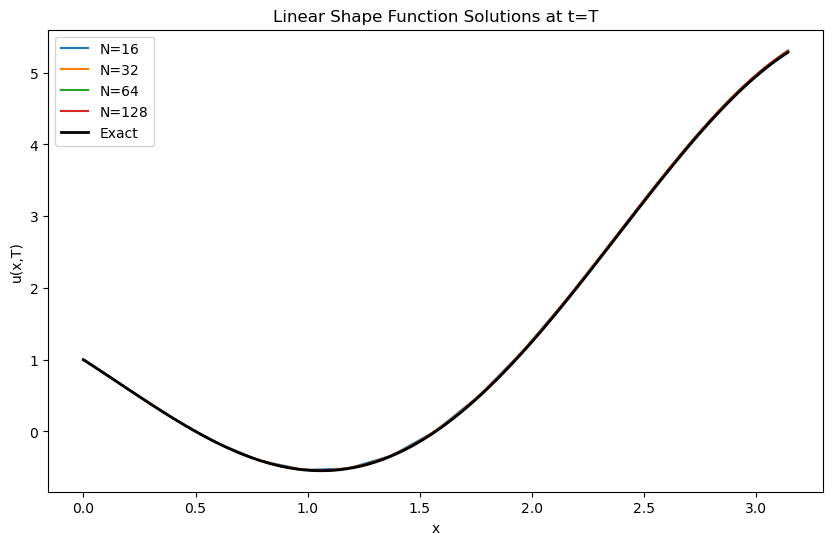

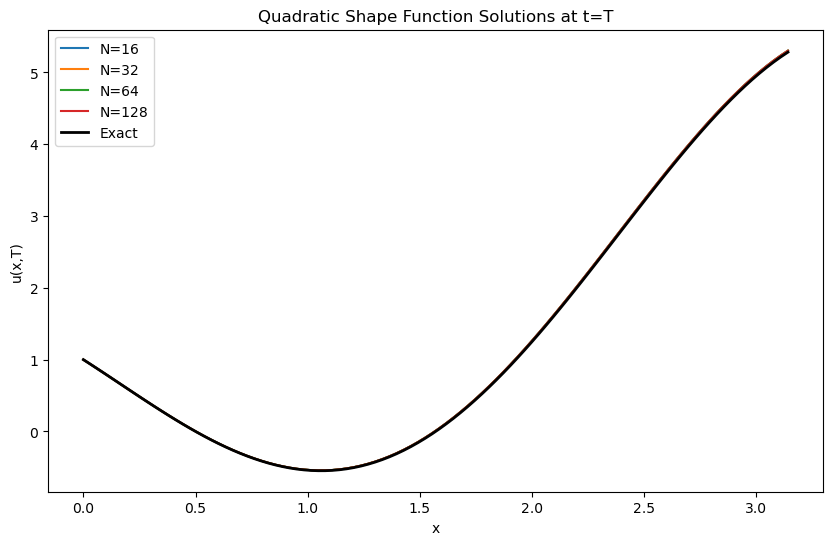

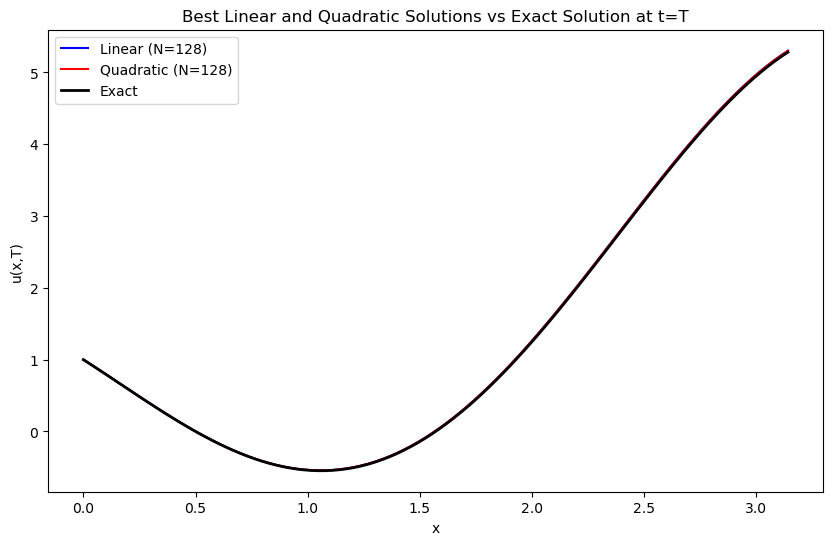

In [35]:
# Create evaluation points
x_vals = np.linspace(0, L, 100)
t_final = T

# Linear Shape Functions vs Exact Solution
plt.figure(figsize=(10, 6))
for noOfEle in element_counts:
    uh = linear_solutions[noOfEle][-1] 
    plt.plot(x_vals, uh(x_vals), label=f'N={noOfEle}')
plt.plot(x_vals, exact_solution(x_vals, t_final), 'k', linewidth=2, label='Exact')
plt.title('Linear Shape Function Solutions at t=T')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.legend()
plt.show()

# Quadratic Shape Functions vs Exact Solution
plt.figure(figsize=(10, 6))
for noOfEle in element_counts:
    uh = quadratic_solutions[noOfEle][-1]
    plt.plot(x_vals, uh(x_vals), label=f'N={noOfEle}')
plt.plot(x_vals, exact_solution(x_vals, t_final), 'k', linewidth=2, label='Exact')
plt.title('Quadratic Shape Function Solutions at t=T')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.legend()
plt.show()

# Best Linear vs Best Quadratic vs Exact
plt.figure(figsize=(10, 6))
uh_linear = linear_solutions[128][-1]
uh_quad = quadratic_solutions[128][-1]
plt.plot(x_vals, uh_linear(x_vals), 'b-', label='Linear (N=128)')
plt.plot(x_vals, uh_quad(x_vals), 'r-', label='Quadratic (N=128)')
plt.plot(x_vals, exact_solution(x_vals, t_final), 'k', linewidth=2, label='Exact')
plt.title('Best Linear and Quadratic Solutions vs Exact Solution at t=T')
plt.xlabel('x')
plt.ylabel('u(x,T)')
plt.legend()
plt.show()

#### Observations

At time $t=T=1$, both linear and quadratic shape function solutions converge to the exact solution $(1-2xt)\cos(x)$ for all cases where the domain is discretized into 16, 32, 64, and 128 subintervals.

For all cases for the number of subintervals considered, although the linear and quadratic shape function solutions produce piecewise linear approximations, the approximations of the true solution are almost identical to the exact solution. 


### 5. Plot of Absolute Differences of Exact Solution and Computed Solutions

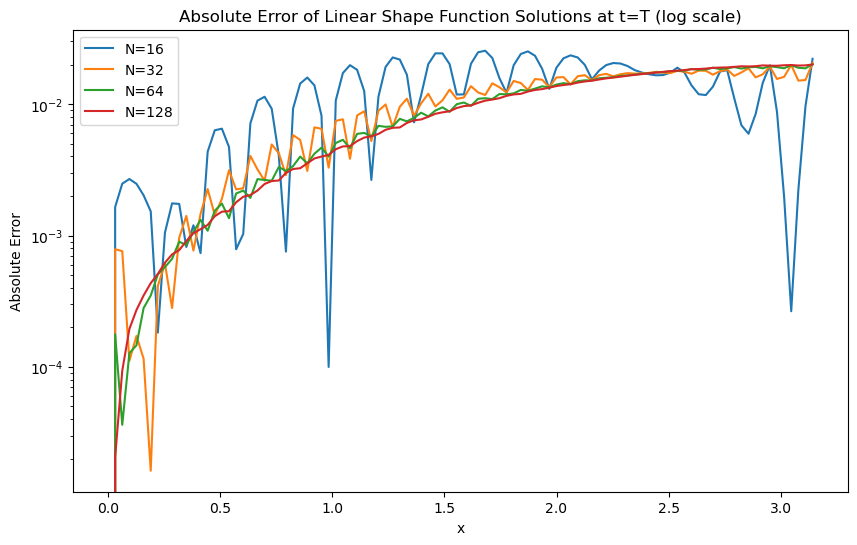

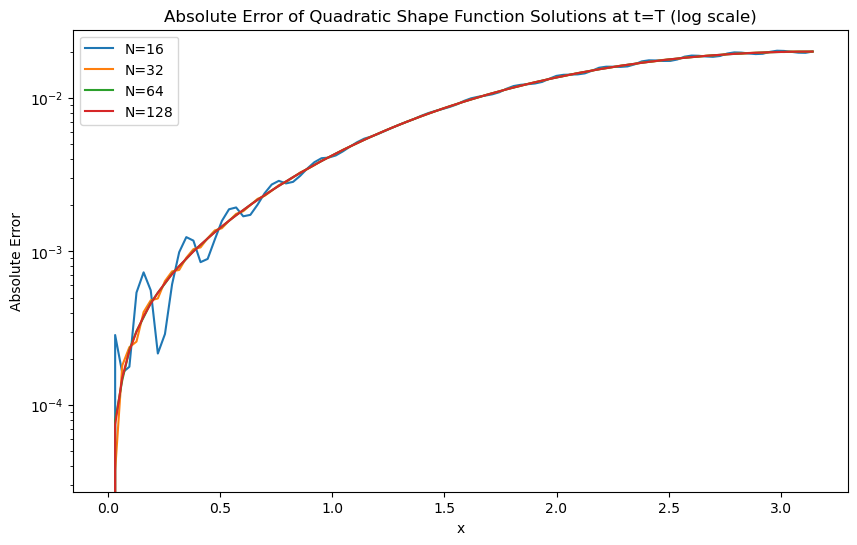

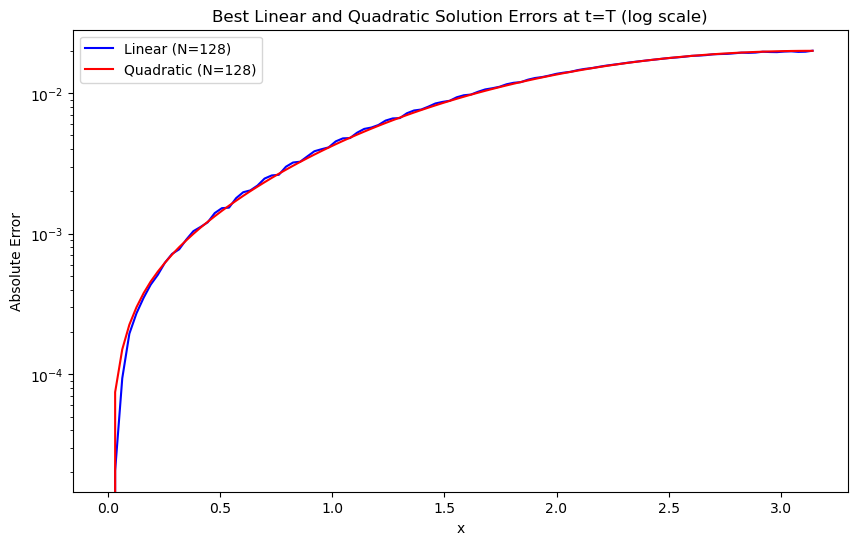

In [39]:
# Linear Shape Function Errors (log scale)
plt.figure(figsize=(10, 6))
for noOfEle in element_counts:
    uh = linear_solutions[noOfEle][-1]
    error = np.abs(uh(x_vals) - exact_solution(x_vals, t_final))
    plt.semilogy(x_vals, error, label=f'N={noOfEle}')
plt.title('Absolute Error of Linear Shape Function Solutions at t=T (log scale)')
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Quadratic Shape Function Errors (log scale)
plt.figure(figsize=(10, 6))
for noOfEle in element_counts:
    uh = quadratic_solutions[noOfEle][-1]
    error = np.abs(uh(x_vals) - exact_solution(x_vals, t_final))
    plt.semilogy(x_vals, error, label=f'N={noOfEle}')
plt.title('Absolute Error of Quadratic Shape Function Solutions at t=T (log scale)')
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Best Linear vs Best Quadratic Errors
plt.figure(figsize=(10, 6))
uh_linear = linear_solutions[128][-1]
uh_quad = quadratic_solutions[128][-1]
error_linear = np.abs(uh_linear(x_vals) - exact_solution(x_vals, t_final))
error_quad = np.abs(uh_quad(x_vals) - exact_solution(x_vals, t_final))
plt.semilogy(x_vals, error_linear, 'b-', label='Linear (N=128)')
plt.semilogy(x_vals, error_quad, 'r-', label='Quadratic (N=128)')
plt.title('Best Linear and Quadratic Solution Errors at t=T (log scale)')
plt.xlabel('x')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

#### Observations

At time $t=T=1$, the linear shape function solutions produce absolute errors that demonstrate oscillatory behavior throughout the entire domain $x \in [0,\pi]$. Additionally, in the linear case, the oscillatory behavior is reduced as the number of elements is increased. For the quadratic shape function solutions, the absolute errors show significantly reduced oscillatory behavior throughout the entire domain $x \in [0,\pi]$ and is more smooth. 

For both the linear and quadratic cases, the absolute error decreases with increasing number of elements. Between the best linear and the best quadratic shape function solution absolute errors at time $t=T=1$, the error in best linear case still displays oscillatory behavior while the error in the quadratic case is smooth. Generally, the resulting absolute error plots can indicate that quadratic shape function solutions produce less error than linear shape function solutions.

### 6. Absolute Differences between Approximated and True Solution (128 subintervals)

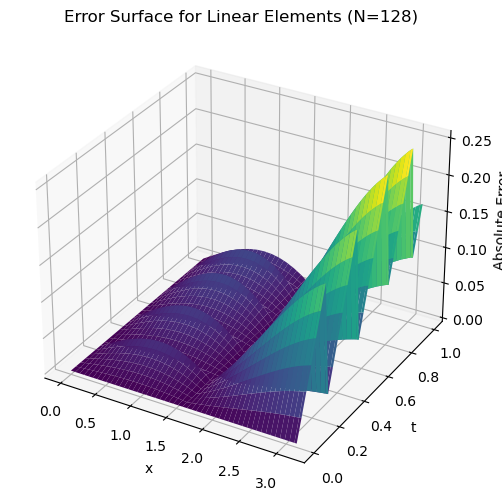

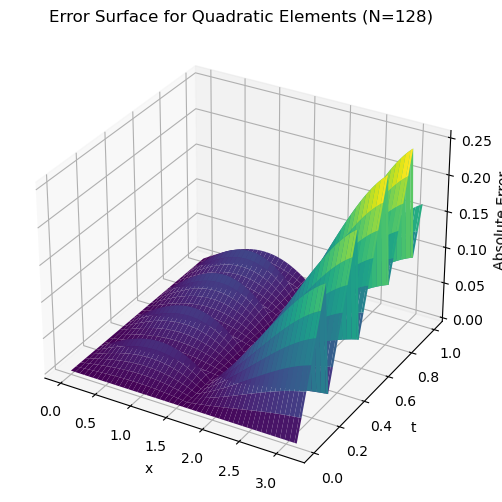

In [43]:
# Create time and space grids
x_plot = np.linspace(0, L, 100)
t_plot = np.linspace(0, T, 30)
X, T_mesh = np.meshgrid(x_plot, t_plot)

# Compute exact solution on grid
exact = exact_solution(X, T_mesh)

# Compute errors for linear elements
uh_linear = linear_solutions[128]
error_linear = np.zeros_like(X)
for i, t in enumerate(t_plot):
    n = int(t / dt)
    error_linear[i,:] = np.abs(uh_linear[n](x_plot) - exact_solution(x_plot, t))

# Compute errors for quadratic elements
uh_quad = quadratic_solutions[128]
error_quad = np.zeros_like(X)
for i, t in enumerate(t_plot):
    n = int(t / dt)
    error_quad[i,:] = np.abs(uh_quad[n](x_plot) - exact_solution(x_plot, t))

# Linear Element Error Surface
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_mesh, error_linear, cmap='viridis')
ax.set_title('Error Surface for Linear Elements (N=128)')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Absolute Error')
plt.show()

# Quadratic Element Error Surface
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, T_mesh, error_quad, cmap='viridis')
ax.set_title('Error Surface for Quadratic Elements (N=128)')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Absolute Error')
plt.show()

#### Observations

Within the error plots over the domain $(x,t) \in [0,\pi] x [0,L]$, the error grows with time for both linear and quadratic methods. Both methods present similar growth in error throughout the domain. For both error plots, the maximum errors occur at peaks that grow as time $t$ approaches $T=1$. Similarly, for both the linear and quadratic case, the error remains grows significantly as $x$ approaches $L=\pi$.

### 7. Convergence of Method and Computed Solutions


Convergence Rates:
 Number of Elements         Linear Order      Quadratic Order
                 16 [1.9937404366070715] [2.9959311747941695]
                 32 [1.9979507289551004] [2.9990515826284048]
                 64 [1.9999435981183964] [2.9993926997455675]
                128 [2.0000115701099053]  [3.000307490182682]


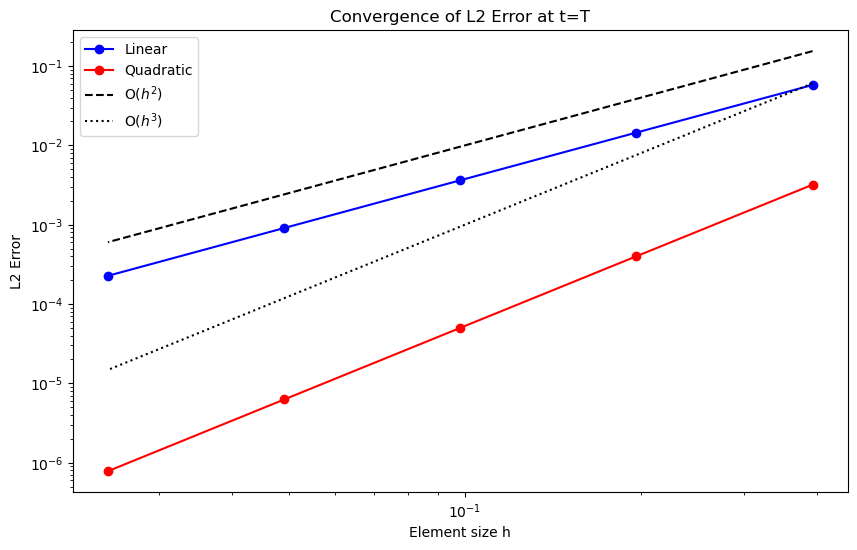

In [47]:
a = lambda x: 2+x
c = lambda x: 1*x
f = lambda x,t: (2 + 2*t - 4*x*t - 4*(x**2)*t)*np.cos(x) + (1 - 8*t - 6*x*t)*np.sin(x)
p0 = 1.
QL = lambda t: 2*t*(np.pi + 2)
u0 = lambda x: np.cos(x)
L = np.pi
T = 1.
dt = 0.01

# Exact solution for comparison
def exact_solution(x, t):
    return np.cos(x) - 2*x*t*np.cos(x)

element_counts = [8, 16, 32, 64, 128]

# Store solutions
linear_solutions = {}
quadratic_solutions = {}

for noOfEle in element_counts:
    # Solve with linear elements
    uh_linear, W_linear = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, 1)
    linear_solutions[noOfEle] = uh_linear
    
    # Solve with quadratic elements
    uh_quad, W_quad = myFE1dibvp(a, c, f, p0, QL, u0, L, T, dt, noOfEle, 2)
    quadratic_solutions[noOfEle] = uh_quad

# Compute L2 errors at t=T
l2_errors_linear = []
l2_errors_quad = []

for noOfEle in element_counts:
    # Linear elements
    uh = linear_solutions[noOfEle][-1]
    error_fn = lambda x: np.abs(uh(x) - exact_solution(x, T))
    l2_error = L2norm1d(error_fn, 0, L, 100)
    l2_errors_linear.append(l2_error)
    
    # Quadratic elements
    uh = quadratic_solutions[noOfEle][-1]
    error_fn = lambda x: np.abs(uh(x) - exact_solution(x, T))
    l2_error = L2norm1d(error_fn, 0, L, 100)
    l2_errors_quad.append(l2_error)

# Calculate convergence rates
def calculate_rates(errors, h_vals):
    rates = []
    for i in range(1, len(errors)):
        rate = np.log(errors[i-1]/errors[i]) / np.log(h_vals[i-1]/h_vals[i])
        rates.append(rate)
    return rates

h_vals = [L/ne for ne in element_counts]
linear_rates = calculate_rates(l2_errors_linear, h_vals)
quadratic_rates = calculate_rates(l2_errors_quad, h_vals)

# Create and display convergence table
import pandas as pd

convergence_table = pd.DataFrame({
    'Number of Elements': element_counts[1:],  
    'Linear Order': linear_rates,
    'Quadratic Order': quadratic_rates
})

print("\nConvergence Rates:")
print(convergence_table.to_string(index=False, float_format="%.4f"))

# Plot convergence
h_vals = [L/ne for ne in element_counts]
plt.figure(figsize=(10, 6))
plt.loglog(h_vals, l2_errors_linear, 'bo-', label='Linear')
plt.loglog(h_vals, l2_errors_quad, 'ro-', label='Quadratic')
plt.loglog(h_vals, [h**2 for h in h_vals], 'k--', label='O($h^{2}$)')
plt.loglog(h_vals, [h**3 for h in h_vals], 'k:', label='O($h^{3}$)')
plt.title('Convergence of L2 Error at t=T')
plt.xlabel('Element size h')
plt.ylabel('L2 Error')
plt.legend()
plt.show()

#### Observations

Calculating the order of convergence for linear and quadratic shape function solution cases reveal that the linear method approaches a convergence of $O(h^2)$ and the quadratic method approaches a convergence of $O(h^3)$ when more subintervals are used in each element.

This can be further observed when plotting log-log plots to demonstrate the convergence of the L2 errors at $t=T=1$ for the linear and quadratic shape function solution approximations, allowing the visual comparison of the convergence rates for each method.

The convergence of the L2 error of the linear case has a slope of approximately 2, indicating the method being second order.
Similarly, the convergence of the L2 error of the quadratic case has a slope of approximately 3, indicating the method third order.

